In [1]:
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
import re
import math
from datetime import datetime, timedelta



/Users/safefleet/Desktop/Bachelor Thesis/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


We partially read the big Frame file with the following function

In [2]:
def read_json_partially(file_path, start_line, end_line):
    data = []  # List to store extracted JSON objects

    with open(file_path, 'r') as file:
        for line_num, line in enumerate(file):
            if line_num >= start_line and line_num <= end_line:
                # Parse JSON from the line and append it to data
                data.append(json.loads(line))
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data


In [3]:
start_line = 0  # Start line number
end_line = 800  # End line number 


StatsPerform data

In [4]:
targetPositions2 = []

file_path2 = '../data/matches/vs FC Lugano/2023-12-06_StatsPerform_FC Lugano - FC fifa format Basel.txt'

with open(file_path2, 'r') as file:
    for index, frame in enumerate(file):
        if(index < start_line):
            continue
        if(index > end_line):
            break
        if(index % 1 != 0): # We consider only every n-th frame
            continue
        f = re.split(',|;', frame)
        for idx, val in enumerate(f):
            if(val == "552970"):
                targetPositions2.append([float(f[idx+2]), float(f[idx+3]), 0, datetime.strptime(f[1], "%f")])
                break

# print(targetPositions2[0])
    # defining datapoints d_i = [x_Coordinate, y_Coordinate, speed, time]

We extract trajectory of targeted player by **ID**

**ReSpo**

In [5]:
file_path = '../data/matches/vs FC Lugano/2023-12-06_ReSpo Vision_FC Lugano - FC Basel.jsonl'
partialframes = read_json_partially(file_path, start_line, end_line)

targetID = 27
targetPositions = []

for index, frame in enumerate(partialframes):
    if(index % 1 != 0): # We consider only every n-th frame
        continue

    player = list(filter(lambda player: player['person_id'] == targetID, frame['players']))[0]

    # defining datapoints d_i = [x_Coordinate, y_Coordinate, speed, time]
    targetPositions.append([player['x'], player['y'], player['speed'], datetime.strptime(frame['time'], "%M:%S.%f")])


**Skillcorner**

In [7]:
# takes as input array of length 3
def getCircle(points):
    assert(len(points) == 3)
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    s1 = x1**2 + y1**2
    s2 = x2**2 + y2**2
    s3 = x3**2 + y3**2
    M11 = x1*y2 + x2*y3 + x3*y1 - (x2*y1 + x3*y2 + x1*y3)
    M12 = s1*y2 + s2*y3 + s3*y1 - (s2*y1 + s3*y2 + s1*y3)
    M13 = s1*x2 + s2*x3 + s3*x1 - (s2*x1 + s3*x2 + s1*x3)
    x0 =  0.5*M12/M11
    y0 = -0.5*M13/M11
    r0 = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return ((x0, y0), r0)

source: https://paulbourke.net/geometry/circlesphere/

In [8]:
def getCircleIntersections(c0, r0, c1, r1):
    x0, y0 = c0
    x1, y1 = c1
    d = math.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    # non intersecting
    if d > r0 + r1 :
        return None
    # One circle within other
    if d < abs(r0-r1):
        return None
    # coincident circles
    if d == 0 and r0 == r1:
        return None
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=math.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 

        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return ((x3, y3), (x4, y4))

In [9]:
def euclidianDistance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [10]:
def closestPoint(p1, p2, p3, p4):
    if(euclidianDistance(p1, p3) + euclidianDistance(p1, p4) < euclidianDistance(p2, p3) + euclidianDistance(p2, p4)):
        return p1
    else:
        return p2

In [11]:
def areCollinear(p1, p2, p3):
    x1, y1 = p2[0] - p1[0], p2[1] - p1[1]
    x2, y2 = p3[0] - p1[0], p3[1] - p1[1]
    return abs(x1 * y2 - x2 * y1) < 1e-12

In [12]:
def midPoint(p1, p2):
    return ((p1[0] + p2[0])/2, (p1[1] + p2[1])/2)

In [13]:
def getAngle(p1, p2, p3):
    a = np.array([p1[0], p1[1]])
    b = np.array([p2[0], p2[1]])
    c = np.array([p3[0], p3[1]])
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    assert(angle <= 2*math.pi and angle >= 0)
    return angle

The following function computes the interpolated new_points according to the definition given in the written report.

In [14]:
def computeNewPoints(datapoints):
    new_points = []
    trajectory = list(map(lambda x: x[:2], datapoints)) 
    n = len(trajectory)

    for i in range(1, n-2):
        if(i == 1):
            p1 = trajectory[i]
            p2 = trajectory[i+1]
            # We assume that between frames the time interval is kept constant. If this is not the case move t12 and t12delta outside of the if statement
            t12 = (datapoints[i+1][3] - datapoints[i][3]).total_seconds()
            t12delta = timedelta(seconds=t12/2)
            col1 = areCollinear(trajectory[i-1], p1, p2)            
        else:
            p1 = p2
            c1 = c2
            r1 = r2
            col1 = col2
    
        p2 = trajectory[i+1]
        M = midPoint(p1, p2)
        
        # handling collinear points
        col2 = areCollinear(trajectory[i+2], p1, p2)

        if(not(col1 or col2)):
            if(i == 1):
                c1, r1 = getCircle(trajectory[i-1: i+2])
            c2, r2 = getCircle(trajectory[i: i+3])
            r = 2/(1/r1 + 1/r2)

        elif(col1 and col2):
            new_point = M
            new_points.append([new_point[0], new_point[1]] + [euclidianDistance(p1, p2)/t12, datapoints[i][3] + t12delta])
            c2 = (0, 0)
            r2 = float('inf')
            continue

        elif(col1):
            c2, r2 = getCircle(trajectory[i: i+3])
            c1 = (0, 0)
            r1 = float('inf')
            r = 2/(1/r2)

        elif(col2):
            if(i == 1):
                c1, r1 = getCircle(trajectory[i-1: i+2])
            c2 = (0, 0)
            r2 = float('inf')
            r = 2/(1/r1)

        # intersecting the averaging circles
        c_avg1, c_avg2 = getCircleIntersections(p1, r, p2, r)

        # if different oriented curvature in the sequential circles than take the shape of the one with the smallest radius
        min_c = c1 if r1 < r2 else c2
        c_avg = c_avg1 if euclidianDistance(c_avg1, min_c) < euclidianDistance(c_avg2, min_c) else c_avg2
        
        # computing new point
        d = r/euclidianDistance(M, c_avg)
        new_point_1 = np.array(c_avg) + (np.array(M)-np.array(c_avg))*d
        new_point_2 = np.array(c_avg) + (np.array(M)-np.array(c_avg))*(-d)

        new_point = closestPoint(new_point_1, new_point_2, p1, p2)
        new_point = [new_point[0], new_point[1], r*getAngle(p1, c_avg, p2)/t12, datapoints[i][3] + t12delta]

        new_points.append(new_point)

    return new_points


**performSmoothing** works in each iteration the following way:<br>
<br>
                1. The interpolated new_points from the **original trajectory** are computed (case i % 2 == 0) <br>
                2. The updated trajectory is computed as interpolated new_points of the previously computed new_point <br>
    
In both cases we extend the trajectories that we pass to the computeNewPoints function,
so that all original points except the first and last get updated every iteration.

In [15]:
def performSmoothing(datapoints, iterations):
    
    # compute extension points at the beginning/end of the trajectory
    pFirst = [2*datapoints[0][0] - datapoints[1][0], 2*datapoints[0][1] - datapoints[1][1], 0, datapoints[0][3] - (datapoints[1][3] - datapoints[0][3])]
    pLast = [2*datapoints[-1][0] - datapoints[-2][0], 2*datapoints[-1][1] - datapoints[-2][1], 0, datapoints[-1][3] + (datapoints[-1][3] - datapoints[-2][3])]
    midFirst = midPoint(pFirst, datapoints[0])
    midLast = midPoint(datapoints[-1], pLast)
    midFirst = [midFirst[0], midFirst[1], 0, datapoints[0][3] - (datapoints[1][3] - datapoints[0][3])/2]
    midLast = [midLast[0], midLast[1], 0, datapoints[-1][3] + (datapoints[-1][3] - datapoints[-2][3])/2]

    for _ in range(0, iterations):
        for i in range(0, 2):
            if(i % 2 != 0):
                og = datapoints.copy()
                updated_datapoints = computeNewPoints([midFirst] + new_points + [midLast])
                datapoints = [og[0]] + updated_datapoints + [og[-1]]
            else:
                new_points = computeNewPoints([pFirst] + datapoints + [pLast])
    return datapoints

Current file has granularity of **40ms**

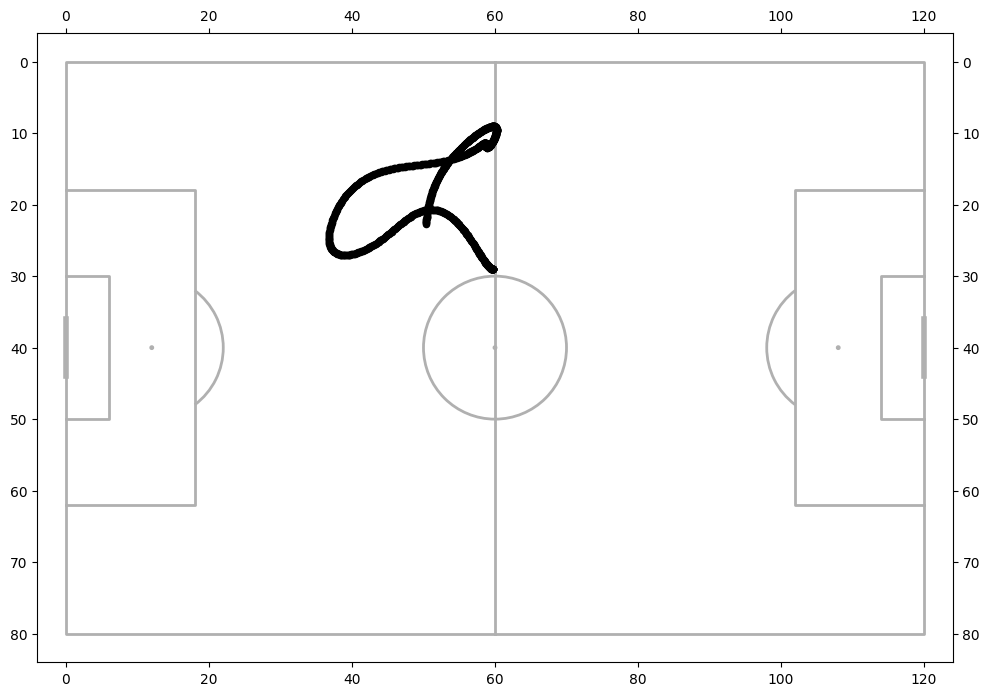

In [16]:
# pitch = Pitch(axis=True, label=True, tick=True, pitch_length=105, pitch_width=68)
# # specifying figure size (width, height)
# fig, ax = pitch.draw(figsize=(10, 20))

# x, y, s, t = zip(*targetPositions)
# ax.scatter(x, y, color='black', marker='o', s=20)
# pFirst = (2*targetPositions[0][0] - targetPositions[1][0], 2*targetPositions[0][1] - targetPositions[1][1])
# pLast = (2*targetPositions[-1][0] - targetPositions[-2][0], 2*targetPositions[-1][1] - targetPositions[-2][1])


# ax.set_xlim(50, 60) 
# ax.set_ylim(40, 30)

# print(targetPositions[-1])
# print(targetPositions2[-1])

# traj = performSmoothing(datapoints=targetPositions2, iterations=1000)
# x, y, s, t = zip(*(traj))

# for idx, t in enumerate(traj):
#     ax.scatter(t[0], t[1], color="purple", marker="o", s=10)
    # ax.text(t[0], t[1], f'(smoothened speed:{t[2]}) original: {targetPositions[idx][2]}')


# ax.scatter(pFirst[0], pFirst[1], color="green", marker="x", s=10)
# ax.scatter(pLast[0], pLast[1], color="green", marker="x", s=10)

# x, y = zip(*(new_points))
# ax.scatter(x, y, color="green", marker="o", s=40)

# plt.show()

distance produced from original points, at some point distance will become very large, and gain in smoothness will be marginal
so try to smooth the speed as much as possible without moving the points as much as possible

speed time series
distance time series

Dynamic time warping 
**Lock step distance**

frechet distance 
haussdorff distance

quantifying volatility - similarities to stock trading

automatic event detection in football using tracking data ferran vidal-codina

(adaptive subsampling)